# Project 1: Multiple Linear and Polynomial Regression
## Course: UTK COSC 528
## Author: Ian R. Stewart

In [1]:
'''
Performs multiple linear and polynomial regression of auto_data.mpg dataset.

Note: To run this python notebook change the variable <inPath> below to the
        path to the auto-mpg.data file.

@ian_r_stewart
'''

inPath = '/Users/i6o/Documents/COSC 528/Project 1/'

In [2]:
import numpy as np
import pandas as pd
from pandas.plotting import table
import matplotlib.pyplot as plt
%matplotlib inline  
import pprint
import random
import warnings
warnings.filterwarnings("ignore")

# Importing scikit-learn to compare results
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

In [338]:
def project1(data,labels):
    '''
    Description: function returns pandas.DataFrame from CSV

    :param data:   {string} : /path/to/filename
    :param labels: {list}   : list of feature labels

    :return: pandas.Dataframe from <data> file with <label> features
    '''

    df = pd.read_csv(data,sep='\s+',names=labels)
    return df

def test_split(data_x,data_y,n):
    '''
    Description: Splits <data> variable into four random 
        parts based on <n> percentage of data for training 
        set.
    
    :param data_x {array} : x data to split,train,predict
    :param data_y {array} : y data to split,train,predict
    :param n      {float} : percentage of data to split
    
    :returns {6}: (x_train,x_test,y_train,y_test) ;     
        x_train = training set for <x> parameter
        x_test  = test set for <x> parameter
        y_train = training set for <y> paramter
        y_test  = test set for <y> parameter
        i_train = index of training set split
        i_test  = index of test set split
    
    e.g. x_tr,x,y_tr,y,i_tr,i_test=test_split(data,data_to_predict,40)
    '''
    data_x = np.concatenate((np.ones([data_x.shape[0],1]),data_x),axis=1)
    length_test = int(round(len(data_x)*(n/100.)))
    # Create random integers between two numbers with no repeats
    train_list = random.sample(range(0,len(data_x)), length_test)
    train_list.sort()
    test_list = np.arange(0,len(data_x))
    test_list = np.delete(test_list,train_list)
    data_y = np.array(data_y)
    x_train,y_train = np.array(data_x[train_list]),np.array(data_y[train_list])
    x_test,y_test   = np.array(data_x[test_list]),np.array(data_y[test_list])
    
    return (x_train,x_test,y_train,y_test,train_list,list(test_list))

def linear_weights(x,y,y_testset):
    '''
    Description: Calculates weight coefficients for Linear Regression
    
    :param x : Augmented data matrix
    :param y : Target data matrix (column)
    :param y_testset : Target data matrix for testing (column)
    
    :returns {3}: (weights,predicted_values,error_fit)
    '''
    weights = np.linalg.inv(x.T.dot(x)).dot(x.T.dot(y))
    predicted_values = [p.dot(weights[1::])+weights[0] for p in x[:,1::]]
    error_fit = np.sum([(a-b)**2 for a,b in zip(predicted_values,y_testset)])/len(y_testset)

    return weights,predicted_values,error_fit

In [339]:
features = ['MPG','Cylinders','Displacement','Horsepower',\
            'Weight','Acceleration','Model Year','Origin','Car Name']

df = project1(inPath+'auto-mpg.data',features)

# Setting values '?' to mean in Horsepower feature
indexs = df.loc[df['Horsepower'] == '?'].index
for i in indexs:
    df.set_value(i,'Horsepower',-1)
df.Horsepower = df.Horsepower.astype('float64')
# Observe '?' in value; removing data from DataFrame
# Printing shape of DataFrame to verify data change
df['Horsepower'][indexs] = df['Horsepower'].mean()

**Note**: Normalizing data and removing "Car Name" as the feature is unique for each observation.

In [340]:
# z-Standardizing the data
df_normed=(df.iloc[:,0:-1]-df.iloc[:,0:-1].mean())/df.iloc[:,0:-1].std()

#### Linear Regression - Comparing calculation to Scikit-Learn Library to improve model confidence (Only for comparison purposes)

In [341]:
error_training = {}; error_test = {}
x_total = df_normed.iloc[:,1::]
y = df_normed.iloc[:,0:1].values

X_tr,X_test,y_tr,y_test,i_tr,i_test = test_split(x_total,y,30)
weights,y_pred_tr,error_tr = linear_weights(X_tr,y_tr,y_tr)

# Scikit-learn regresssion (Comparison purposes only)
lm = LinearRegression()
model = lm.fit(X_tr,y_tr)
model_predict = lm.predict(X_test)
predicted_values = [x.dot(weights[1::])+weights[0] for x in X_test[:,1::]]
error_fit = np.sum([(a-b)**2 for a,b in zip(predicted_values,y_test)])/len(y_test) 

pprint.pprint('SciKit Learn LR Coefficients: %s'%str(lm.coef_[0][1::]))
pprint.pprint('Calculated Coefficients: %s'%[float(x) for x in weights[1::]])
pprint.pprint('Error in training: %.4f'%error_tr)
pprint.pprint('Error in test: %.4f'%error_fit)

error_training['All'] = error_tr
error_test['All'] = error_fit

'SciKit Learn LR Coefficients: [-0.24073972  0.44776478 -0.17394192 -0.66742622  0.01162506  0.35506173\n  0.16615319]'
'Calculated Coefficients: [-0.24073971813092054, 0.44776477839867646, -0.17394192183709478, -0.6674262244741254, 0.011625055006618368, 0.35506173260156226, 0.16615319262842926]'
'Error in training: 0.1304'
'Error in test: 0.2040'


**NOTE**: With confirmation that the fit is identical to python's scikit-learn library, each combination is tested using the same methodology. The scikit-learn was utilized to provide user confidence in calculated coefficient values. The following cell will calculate the fit error in dropping specific features and will be used to evaluate the ideal features for predicting MPG.

## **Linear Regression Feature-dropping study [Standardized Data]**

In [344]:
x = df_normed.iloc[:,2::]
x = np.concatenate((np.ones([x.shape[0],1]),x),axis=1)
y = df_normed.iloc[:,0:1].values

X_tr,X_test = x[i_tr],x[i_test]
y_tr,y_test = y[i_tr],y[i_test]

weights,y_pred_tr,error_tr = linear_weights(X_tr,y_tr,y_tr)

# Scikit-learn regresssion
lm = LinearRegression()
model = lm.fit(X_tr,y_tr)
model_predict = lm.predict(X_test)
predicted_values = [x.dot(weights[1::])+weights[0] for x in X_test[:,1::]]
error_fit = np.sum([(a-b)**2 for a,b in zip(predicted_values,y_test)])/len(y_test) 

error_training['Cylinders'] = error_tr
error_test['Cylinders'] = error_fit
# ----------------------------------------------------#

x = df_normed.iloc[:,3::]
x = np.concatenate((np.ones([x.shape[0],1]),x),axis=1)
y = df_normed.iloc[:,0:1].values

X_tr,X_test = x[i_tr],x[i_test]
y_tr,y_test = y[i_tr],y[i_test]

weights,y_pred_tr,error_tr = linear_weights(X_tr,y_tr,y_tr)

predicted_values = [x.dot(weights[1::])+weights[0] for x in X_test[:,1::]]
error_fit = np.sum([(a-b)**2 for a,b in zip(predicted_values,y_test)])/len(y_test) 

error_training['Displacement'] = error_tr
error_test['Displacement'] = error_fit
# ----------------------------------------------------#

x = df_normed.iloc[:,4::]
x = np.concatenate((np.ones([x.shape[0],1]),x),axis=1)
y = df_normed.iloc[:,0:1].values

X_tr,X_test = x[i_tr],x[i_test]
y_tr,y_test = y[i_tr],y[i_test]

weights,y_pred_tr,error_tr = linear_weights(X_tr,y_tr,y_tr)

predicted_values = [x.dot(weights[1::])+weights[0] for x in X_test[:,1::]]
error_fit = np.sum([(a-b)**2 for a,b in zip(predicted_values,y_test)])/len(y_test) 

error_training['Horsepower'] = error_tr
error_test['Horsepower'] = error_fit
# ----------------------------------------------------#

x = df_normed.iloc[:,5::]
x = np.concatenate((np.ones([x.shape[0],1]),x),axis=1)
y = df_normed.iloc[:,0:1].values

X_tr,X_test = x[i_tr],x[i_test]
y_tr,y_test = y[i_tr],y[i_test]

weights,y_pred_tr,error_tr = linear_weights(X_tr,y_tr,y_tr)

predicted_values = [x.dot(weights[1::])+weights[0] for x in X_test[:,1::]]
error_fit = np.sum([(a-b)**2 for a,b in zip(predicted_values,y_test)])/len(y_test) 

error_training['Weight'] = error_tr
error_test['Weight'] = error_fit
# ----------------------------------------------------#

x = df_normed.iloc[:,6::]
x = np.concatenate((np.ones([x.shape[0],1]),x),axis=1)
y = df_normed.iloc[:,0:1].values

X_tr,X_test = x[i_tr],x[i_test]
y_tr,y_test = y[i_tr],y[i_test]

weights,y_pred_tr,error_tr = linear_weights(X_tr,y_tr,y_tr)

error_training['Acceleration'] = error_tr
error_test['Acceleration'] = error_fit
# ----------------------------------------------------#

x = df_normed.iloc[:,7::]
x = np.concatenate((np.ones([x.shape[0],1]),x),axis=1)
y = df_normed.iloc[:,0:1].values

X_tr,X_test = x[i_tr],x[i_test]
y_tr,y_test = y[i_tr],y[i_test]

weights,y_pred_tr,error_tr = linear_weights(X_tr,y_tr,y_tr)

predicted_values = [x.dot(weights[1::])+weights[0] for x in X_test[:,1::]]
error_fit = np.sum([(a-b)**2 for a,b in zip(predicted_values,y_test)])/len(y_test) 

error_training['Model Year'] = error_tr
error_test['Model Year'] = error_fit
# ----------------------------------------------------#

x = df_normed.iloc[:,8::]
x = np.concatenate((np.ones([x.shape[0],1]),x),axis=1)
y = df_normed.iloc[:,0:1].values

X_tr,X_test = x[i_tr],x[i_test]
y_tr,y_test = y[i_tr],y[i_test]

weights,y_pred_tr,error_tr = linear_weights(X_tr,y_tr,y_tr)

predicted_values = [x.dot(weights[1::])+weights[0] for x in X_test[:,1::]]
error_fit = np.sum([(a-b)**2 for a,b in zip(predicted_values,y_test)])/len(y_test) 

error_training['Origin'] = error_tr
error_test['Origin'] = error_fit
# ----------------------------------------------------#
sorted_array = features[1:-1]; 
sorted_array.insert(0,'All')
print '--- Training Error ----'
for i in sorted_array:
    print '%s : %.4f'%(i,error_training[i])
print '-----------------------'
print '\n---- Test Error -----'
for i in sorted_array:
    print '%s : %.4f'%(i,error_test[i])
print '-----------------------'

--- Training Error ----
All : 0.1304
Cylinders : 0.1361
Displacement : 0.1401
Horsepower : 0.1409
Weight : 0.3655
Acceleration : 0.3933
Model Year : 0.6482
Origin : 1.0608
-----------------------

---- Test Error -----
All : 0.2040
Cylinders : 0.2000
Displacement : 0.2011
Horsepower : 0.1998
Weight : 0.4299
Acceleration : 0.4299
Model Year : 0.7016
Origin : 0.9712
-----------------------


## **Linear Regression Feature-dropping study [Non-standardized Data]**

In [345]:
x = df.iloc[:,2:-1]
x = np.concatenate((np.ones([x.shape[0],1]),x),axis=1)
y = df.iloc[:,0:1].values

X_tr,X_test = x[i_tr],x[i_test]
y_tr,y_test = y[i_tr],y[i_test]

weights,y_pred_tr,error_tr = linear_weights(X_tr,y_tr,y_tr)

predicted_values = [x.dot(weights[1::])+weights[0] for x in X_test[:,1::]]
error_fit = np.sum([(a-b)**2 for a,b in zip(predicted_values,y_test)])/len(y_test) 

error_training['Cylinders'] = error_tr
error_test['Cylinders'] = error_fit
# ----------------------------------------------------#

x = df.iloc[:,3:-1]
x = np.concatenate((np.ones([x.shape[0],1]),x),axis=1)
y = df.iloc[:,0:1].values

X_tr,X_test = x[i_tr],x[i_test]
y_tr,y_test = y[i_tr],y[i_test]

weights,y_pred_tr,error_tr = linear_weights(X_tr,y_tr,y_tr)

predicted_values = [x.dot(weights[1::])+weights[0] for x in X_test[:,1::]]
error_fit = np.sum([(a-b)**2 for a,b in zip(predicted_values,y_test)])/len(y_test) 

error_training['Displacement'] = error_tr
error_test['Displacement'] = error_fit
# ----------------------------------------------------#

x = df.iloc[:,4:-1]
x = np.concatenate((np.ones([x.shape[0],1]),x),axis=1)
y = df.iloc[:,0:1].values

X_tr,X_test = x[i_tr],x[i_test]
y_tr,y_test = y[i_tr],y[i_test]

weights,y_pred_tr,error_tr = linear_weights(X_tr,y_tr,y_tr)

predicted_values = [x.dot(weights[1::])+weights[0] for x in X_test[:,1::]]
error_fit = np.sum([(a-b)**2 for a,b in zip(predicted_values,y_test)])/len(y_test) 

error_training['Horsepower'] = error_tr
error_test['Horsepower'] = error_fit
# ----------------------------------------------------#

x = df.iloc[:,5:-1]
x = np.concatenate((np.ones([x.shape[0],1]),x),axis=1)
y = df.iloc[:,0:1].values

X_tr,X_test = x[i_tr],x[i_test]
y_tr,y_test = y[i_tr],y[i_test]

weights,y_pred_tr,error_tr = linear_weights(X_tr,y_tr,y_tr)

predicted_values = [x.dot(weights[1::])+weights[0] for x in X_test[:,1::]]
error_fit = np.sum([(a-b)**2 for a,b in zip(predicted_values,y_test)])/len(y_test) 

error_training['Weight'] = error_tr
error_test['Weight'] = error_fit
# ----------------------------------------------------#

x = df.iloc[:,6:-1]
x = np.concatenate((np.ones([x.shape[0],1]),x),axis=1)
y = df.iloc[:,0:1].values

X_tr,X_test = x[i_tr],x[i_test]
y_tr,y_test = y[i_tr],y[i_test]

weights,y_pred_tr,error_tr = linear_weights(X_tr,y_tr,y_tr)

predicted_values = [x.dot(weights[1::])+weights[0] for x in X_test[:,1::]]
error_fit = np.sum([(a-b)**2 for a,b in zip(predicted_values,y_test)])/len(y_test) 

error_training['Acceleration'] = error_tr
error_test['Acceleration'] = error_fit
# ----------------------------------------------------#

x = df.iloc[:,7:-1]
x = np.concatenate((np.ones([x.shape[0],1]),x),axis=1)
y = df.iloc[:,0:1].values

X_tr,X_test = x[i_tr],x[i_test]
y_tr,y_test = y[i_tr],y[i_test]

weights,y_pred_tr,error_tr = linear_weights(X_tr,y_tr,y_tr)

predicted_values = [x.dot(weights[1::])+weights[0] for x in X_test[:,1::]]
error_fit = np.sum([(a-b)**2 for a,b in zip(predicted_values,y_test)])/len(y_test) 

error_training['Model Year'] = error_tr
error_test['Model Year'] = error_fit
# ----------------------------------------------------#

x = df.iloc[:,8:-1]
x = np.concatenate((np.ones([x.shape[0],1]),x),axis=1)
y = df.iloc[:,0:1].values

X_tr,X_test = x[i_tr],x[i_test]
y_tr,y_test = y[i_tr],y[i_test]

weights,y_pred_tr,error_tr = linear_weights(X_tr,y_tr,y_tr)

predicted_values = [x.dot(weights[1::])+weights[0] for x in X_test[:,1::]]
error_fit = np.sum([(a-b)**2 for a,b in zip(predicted_values,y_test)])/len(y_test) 

error_training['Origin'] = error_tr
error_test['Origin'] = error_fit
# ----------------------------------------------------#
sorted_array = features[1:-1]; 
sorted_array.insert(0,'All')
print '--- Training Error ----'
for i in sorted_array:
    print '%s : %.4f'%(i,error_training[i])
print '-----------------------'
print '\n---- Test Error -----'
for i in sorted_array:
    print '%s : %.4f'%(i,error_test[i])
print '-----------------------'

--- Training Error ----
All : 0.1304
Cylinders : 8.3127
Displacement : 8.5615
Horsepower : 8.6054
Weight : 22.3258
Acceleration : 24.0240
Model Year : 39.5975
Origin : 64.8054
-----------------------

---- Test Error -----
All : 0.2040
Cylinders : 12.2179
Displacement : 12.2870
Horsepower : 12.2063
Weight : 26.2601
Acceleration : 28.7286
Model Year : 42.8599
Origin : 59.3331
-----------------------


### Utilizing two feature linear regression for Model Year and Weight based on previous error calculation.

### **Hyperparamter Optimization**

[0.17477041517597552, 0.18639342606117515]
[0.12068074264469779, 0.18050600195859817]
[0.03918888218074979, 0.4753046780226692]
[8.391494624659129e-26, 42.824654392515434]


[None, None, None, None]

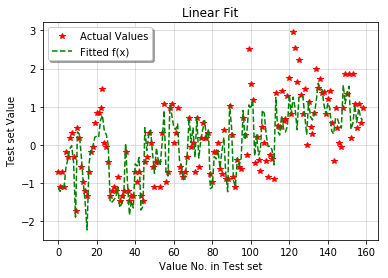

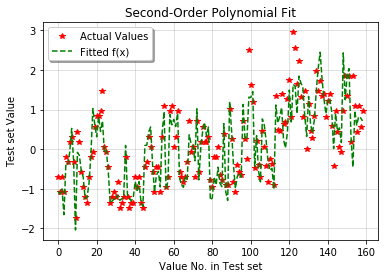

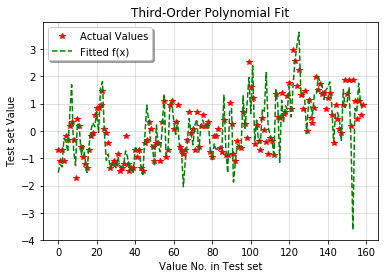

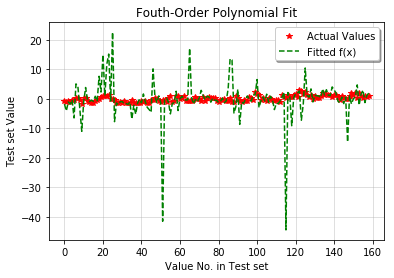

In [348]:
errors = {}
e11=[];e12=[]
e21=[];e22=[]
e31=[];e32=[]
e41=[];e42=[]
for i in range(1):
    y = df_normed.iloc[:,0:1].values
    X_tr,X_test,y_tr,y_test,i_tr,i_test = test_split(df_normed.iloc[:,1::],y,40)

    X_test_sk = np.array(df_normed.iloc[:,1::].drop(df_normed.iloc[:,1::].index[[i_test]]))
    X_tr = np.array(df_normed.iloc[:,1::].drop(df_normed.iloc[:,1::].index[[i_tr]]))
    y_test = np.array(df_normed.iloc[:,0:1].drop(df_normed.iloc[:,0:1].index[[i_test]]))
    y_tr = np.array(df_normed.iloc[:,0:1].drop(df_normed.iloc[:,0:1].index[[i_tr]]))

    poly = PolynomialFeatures(degree=1)
    clf = linear_model.LinearRegression()
    clf.fit(poly.fit_transform(X_tr), y_tr)
    sk_predicted_values = clf.predict(poly.fit_transform(X_test_sk))
    sk_predicted_values_tr = clf.predict(poly.fit_transform(X_tr))
    e11.append(np.sum([(a-b)**2 for a,b in zip(sk_predicted_values_tr,y_tr)])/len(y_tr))
    e12.append(np.sum([(a-b)**2 for a,b in zip(sk_predicted_values,y_test)])/len(y_test))
    plt.figure();plt.plot(y_test,'r*',label='Actual Values');plt.plot(sk_predicted_values,'g--',label='Fitted f(x)');plt.grid(alpha=0.5);plt.legend(fancybox=True,shadow=True);plt.xlabel('Value No. in Test set');plt.ylabel('Test set Value');plt.title('Linear Fit');plt.savefig('/Users/i6o/Desktop/1stfit.png',dpi=400)

    poly = PolynomialFeatures(degree=2)
    clf = linear_model.LinearRegression()
    clf.fit(poly.fit_transform(X_tr), y_tr)
    sk_predicted_values = clf.predict(poly.fit_transform(X_test_sk))
    sk_predicted_values_tr = clf.predict(poly.fit_transform(X_tr))
    e21.append(np.sum([(a-b)**2 for a,b in zip(sk_predicted_values_tr,y_tr)])/len(y_tr))
    e22.append(np.sum([(a-b)**2 for a,b in zip(sk_predicted_values,y_test)])/len(y_test))
    plt.figure();plt.plot(y_test,'r*',label='Actual Values');plt.plot(sk_predicted_values,'g--',label='Fitted f(x)');plt.grid(alpha=0.5);plt.legend(fancybox=True,shadow=True);plt.xlabel('Value No. in Test set');plt.ylabel('Test set Value');plt.title('Second-Order Polynomial Fit');plt.savefig('/Users/i6o/Desktop/2ndfit.png',dpi=400)

    poly = PolynomialFeatures(degree=3)
    clf = linear_model.LinearRegression()
    clf.fit(poly.fit_transform(X_tr), y_tr)
    sk_predicted_values = clf.predict(poly.fit_transform(X_test_sk))
    sk_predicted_values_tr = clf.predict(poly.fit_transform(X_tr))
    e31.append(np.sum([(a-b)**2 for a,b in zip(sk_predicted_values_tr,y_tr)])/len(y_tr))
    e32.append(np.sum([(a-b)**2 for a,b in zip(sk_predicted_values,y_test)])/len(y_test))
    plt.figure();plt.plot(y_test,'r*',label='Actual Values');plt.plot(sk_predicted_values,'g--',label='Fitted f(x)');plt.grid(alpha=0.5);plt.legend(fancybox=True,shadow=True);plt.xlabel('Value No. in Test set');plt.ylabel('Test set Value');plt.title('Third-Order Polynomial Fit');plt.savefig('/Users/i6o/Desktop/3rdfit.png',dpi=400)
    
    poly = PolynomialFeatures(degree=4)
    clf = linear_model.LinearRegression()
    clf.fit(poly.fit_transform(X_tr), y_tr)
    sk_predicted_values = clf.predict(poly.fit_transform(X_test_sk))
    sk_predicted_values_tr = clf.predict(poly.fit_transform(X_tr))
    e41.append(np.sum([(a-b)**2 for a,b in zip(sk_predicted_values_tr,y_tr)])/len(y_tr))
    e42.append(np.sum([(a-b)**2 for a,b in zip(sk_predicted_values,y_test)])/len(y_test))
    plt.figure();plt.plot(y_test,'r*',label='Actual Values');plt.plot(sk_predicted_values,'g--',label='Fitted f(x)');plt.grid(alpha=0.5);plt.legend(fancybox=True,shadow=True);plt.xlabel('Value No. in Test set');plt.ylabel('Test set Value');plt.title('Fouth-Order Polynomial Fit');plt.savefig('/Users/i6o/Desktop/4thfit.png',dpi=400)
    
errors['First'] = [np.mean(e11),np.mean(e12)]
errors['Second'] = [np.mean(e21),np.mean(e22)]
errors['Third'] = [np.mean(e31),np.mean(e32)]
errors['Fourth'] = [np.mean(e41),np.mean(e42)]
[pprint.pprint(errors[x]) for x in ['First','Second','Third','Fourth']]

### **Testing of Quadratic Regression with ONE feature to compare to linear regression**

In [363]:
X_tr,X_test,y_tr,y_test,i_tr,i_test = test_split(df_normed.iloc[:,1::],df_normed.iloc[:,0:1],30)

print '\t\tTraining\tTest\n\t\tError\t\tError'

# Origin
x_total2 = df_normed.iloc[:,7::]
x1_squared = [a**2 for a in np.array(x_total2.iloc[:,0])]
x_total2['x1_squared'] = pd.Series(x1_squared,index=x_total2.index)
x_total2 = np.concatenate((np.ones([x_total2.shape[0],1]),x_total2),axis=1)
y = df_normed.iloc[:,0:1].values

X_tr = x_total2[i_tr]
y_tr = y[i_tr]
X_test = x_total2[i_test]
y_test = y[i_test]

weights_tr,y_pred_tr,error = linear_weights(X_tr,y_tr,y_tr)
predicted_values = [x.dot(weights_tr[1::])+weights_tr[0] for x in X_test[:,1::]]
error_fit = np.sum([(a-b)**2 for a,b in zip(predicted_values,y_test)])/len(y_test)
print 'Origin:\t\t%.4f\t\t%.4f'%(error, error_fit)

# Model Year
x_total2 = df_normed.iloc[:,6:7]
x1_squared = [a**2 for a in np.array(x_total2.iloc[:,0])]
x_total2['x1_squared'] = pd.Series(x1_squared,index=x_total2.index)
x_total2 = np.concatenate((np.ones([x_total2.shape[0],1]),x_total2),axis=1)
y = df_normed.iloc[:,0:1].values

X_tr = x_total2[i_tr]
y_tr = y[i_tr]
X_test = x_total2[i_test]
y_test = y[i_test]

weights_tr,y_pred_tr,error = linear_weights(X_tr,y_tr,y_tr)
predicted_values = [x.dot(weights_tr[1::])+weights_tr[0] for x in X_test[:,1::]]
error_fit = np.sum([(a-b)**2 for a,b in zip(predicted_values,y_test)])/len(y_test)
print 'Model Year:\t%.4f\t\t%.4f'%(error, error_fit)

# Acceleration
x_total2 = df_normed.iloc[:,5:6]
x1_squared = [a**2 for a in np.array(x_total2.iloc[:,0])]
x_total2['x1_squared'] = pd.Series(x1_squared,index=x_total2.index)
x_total2 = np.concatenate((np.ones([x_total2.shape[0],1]),x_total2),axis=1)
y = df_normed.iloc[:,0:1].values

X_tr = x_total2[i_tr]
y_tr = y[i_tr]
X_test = x_total2[i_test]
y_test = y[i_test]

weights_tr,y_pred_tr,error = linear_weights(X_tr,y_tr,y_tr)
predicted_values = [x.dot(weights_tr[1::])+weights_tr[0] for x in X_test[:,1::]]
error_fit = np.sum([(a-b)**2 for a,b in zip(predicted_values,y_test)])/len(y_test)
print 'Acceleration:\t%.4f\t\t%.4f'%(error, error_fit)

# Weight
x_total2 = df_normed.iloc[:,4:5]
x1_squared = [a**2 for a in np.array(x_total2.iloc[:,0])]
x_total2['x1_squared'] = pd.Series(x1_squared,index=x_total2.index)
x_total2 = np.concatenate((np.ones([x_total2.shape[0],1]),x_total2),axis=1)
y = df_normed.iloc[:,0:1].values

X_tr = x_total2[i_tr]
y_tr = y[i_tr]
X_test = x_total2[i_test]
y_test = y[i_test]

weights_tr,y_pred_tr,error = linear_weights(X_tr,y_tr,y_tr)
predicted_values = [x.dot(weights_tr[1::])+weights_tr[0] for x in X_test[:,1::]]
error_fit = np.sum([(a-b)**2 for a,b in zip(predicted_values,y_test)])/len(y_test)
print 'Weight:\t\t%.4f\t\t%.4f'%(error, error_fit)

# Horsepower
x_total2 = df_normed.iloc[:,3:4]
x1_squared = [a**2 for a in np.array(x_total2.iloc[:,0])]
x_total2['x1_squared'] = pd.Series(x1_squared,index=x_total2.index)
x_total2 = np.concatenate((np.ones([x_total2.shape[0],1]),x_total2),axis=1)
y = df_normed.iloc[:,0:1].values

X_tr = x_total2[i_tr]
y_tr = y[i_tr]
X_test = x_total2[i_test]
y_test = y[i_test]

weights_tr,y_pred_tr,error = linear_weights(X_tr,y_tr,y_tr)
predicted_values = [x.dot(weights_tr[1::])+weights_tr[0] for x in X_test[:,1::]]
error_fit = np.sum([(a-b)**2 for a,b in zip(predicted_values,y_test)])/len(y_test)
print 'Horsepower:\t%.4f\t\t%.4f'%(error, error_fit)

# Displacement
x_total2 = df_normed.iloc[:,2:3]
x1_squared = [a**2 for a in np.array(x_total2.iloc[:,0])]
x_total2['x1_squared'] = pd.Series(x1_squared,index=x_total2.index)
x_total2 = np.concatenate((np.ones([x_total2.shape[0],1]),x_total2),axis=1)
y = df_normed.iloc[:,0:1].values

X_tr = x_total2[i_tr]
y_tr = y[i_tr]
X_test = x_total2[i_test]
y_test = y[i_test]

weights_tr,y_pred_tr,error = linear_weights(X_tr,y_tr,y_tr)
predicted_values = [x.dot(weights_tr[1::])+weights_tr[0] for x in X_test[:,1::]]
error_fit = np.sum([(a-b)**2 for a,b in zip(predicted_values,y_test)])/len(y_test)
print 'Displacement:\t%.4f\t\t%.4f'%(error, error_fit)

# Cylinders
x_total2 = df_normed.iloc[:,1:2]
x1_squared = [a**2 for a in np.array(x_total2.iloc[:,0])]
x_total2['x1_squared'] = pd.Series(x1_squared,index=x_total2.index)
x_total2 = np.concatenate((np.ones([x_total2.shape[0],1]),x_total2),axis=1)
y = df_normed.iloc[:,0:1].values

X_tr = x_total2[i_tr]
y_tr = y[i_tr]
X_test = x_total2[i_test]
y_test = y[i_test]

weights_tr,y_pred_tr,error = linear_weights(X_tr,y_tr,y_tr)
predicted_values = [x.dot(weights_tr[1::])+weights_tr[0] for x in X_test[:,1::]]
error_fit = np.sum([(a-b)**2 for a,b in zip(predicted_values,y_test)])/len(y_test)
print 'Cylinders:\t%.4f\t\t%.4f'%(error, error_fit)

		Training	Test
		Error		Error
Origin:		0.6737		0.6716
Model Year:	0.6156		0.6489
Acceleration:	0.7380		0.8755
Weight:		0.2566		0.2971
Horsepower:	0.2527		0.3652
Displacement:	0.2984		0.3174
Cylinders:	0.3773		0.4125


#### Comparing single-feature quadratic regression to single-feature linear regression

In [364]:
print '\t\tTraining\tTest\n\t\tError\t\tError'

# Origin
x_total2 = df_normed.iloc[:,7::]
x_total2 = np.concatenate((np.ones([x_total2.shape[0],1]),x_total2),axis=1)
y = df_normed.iloc[:,0:1].values

X_tr = x_total2[i_tr]
y_tr = y[i_tr]
X_test = x_total2[i_test]
y_test = y[i_test]

weights_tr,y_pred_tr,error = linear_weights(X_tr,y_tr,y_tr)
predicted_values = [x.dot(weights_tr[1::])+weights_tr[0] for x in X_test[:,1::]]
error_fit = np.sum([(a-b)**2 for a,b in zip(predicted_values,y_test)])/len(y_test)
print 'Origin:\t\t%.4f\t\t%.4f'%(error, error_fit)

# Model Year
x_total2 = df_normed.iloc[:,6:7]
x_total2 = np.concatenate((np.ones([x_total2.shape[0],1]),x_total2),axis=1)
y = df_normed.iloc[:,0:1].values

X_tr = x_total2[i_tr]
y_tr = y[i_tr]
X_test = x_total2[i_test]
y_test = y[i_test]

weights_tr,y_pred_tr,error = linear_weights(X_tr,y_tr,y_tr)
predicted_values = [x.dot(weights_tr[1::])+weights_tr[0] for x in X_test[:,1::]]
error_fit = np.sum([(a-b)**2 for a,b in zip(predicted_values,y_test)])/len(y_test)
print 'Model Year:\t%.4f\t\t%.4f'%(error, error_fit)

# Acceleration
x_total2 = df_normed.iloc[:,5:6]
x_total2 = np.concatenate((np.ones([x_total2.shape[0],1]),x_total2),axis=1)
y = df_normed.iloc[:,0:1].values

X_tr = x_total2[i_tr]
y_tr = y[i_tr]
X_test = x_total2[i_test]
y_test = y[i_test]

weights_tr,y_pred_tr,error = linear_weights(X_tr,y_tr,y_tr)
predicted_values = [x.dot(weights_tr[1::])+weights_tr[0] for x in X_test[:,1::]]
error_fit = np.sum([(a-b)**2 for a,b in zip(predicted_values,y_test)])/len(y_test)
print 'Acceleration:\t%.4f\t\t%.4f'%(error, error_fit)

# Weight
x_total2 = df_normed.iloc[:,4:5]
x_total2 = np.concatenate((np.ones([x_total2.shape[0],1]),x_total2),axis=1)
y = df_normed.iloc[:,0:1].values

X_tr = x_total2[i_tr]
y_tr = y[i_tr]
X_test = x_total2[i_test]
y_test = y[i_test]

weights_tr,y_pred_tr,error = linear_weights(X_tr,y_tr,y_tr)
predicted_values = [x.dot(weights_tr[1::])+weights_tr[0] for x in X_test[:,1::]]
error_fit = np.sum([(a-b)**2 for a,b in zip(predicted_values,y_test)])/len(y_test)
print 'Weight:\t\t%.4f\t\t%.4f'%(error, error_fit)

# Horsepower
x_total2 = df_normed.iloc[:,3:4]
x_total2 = np.concatenate((np.ones([x_total2.shape[0],1]),x_total2),axis=1)
y = df_normed.iloc[:,0:1].values

X_tr = x_total2[i_tr]
y_tr = y[i_tr]
X_test = x_total2[i_test]
y_test = y[i_test]

weights_tr,y_pred_tr,error = linear_weights(X_tr,y_tr,y_tr)
predicted_values = [x.dot(weights_tr[1::])+weights_tr[0] for x in X_test[:,1::]]
error_fit = np.sum([(a-b)**2 for a,b in zip(predicted_values,y_test)])/len(y_test)
print 'Horsepower:\t%.4f\t\t%.4f'%(error, error_fit)

# Displacement
x_total2 = df_normed.iloc[:,2:3]
x_total2 = np.concatenate((np.ones([x_total2.shape[0],1]),x_total2),axis=1)
y = df_normed.iloc[:,0:1].values

X_tr = x_total2[i_tr]
y_tr = y[i_tr]
X_test = x_total2[i_test]
y_test = y[i_test]

weights_tr,y_pred_tr,error = linear_weights(X_tr,y_tr,y_tr)
predicted_values = [x.dot(weights_tr[1::])+weights_tr[0] for x in X_test[:,1::]]
error_fit = np.sum([(a-b)**2 for a,b in zip(predicted_values,y_test)])/len(y_test)
print 'Displacement:\t%.4f\t\t%.4f'%(error, error_fit)

# Cylinders
x_total2 = df_normed.iloc[:,1:2]
x_total2 = np.concatenate((np.ones([x_total2.shape[0],1]),x_total2),axis=1)
y = df_normed.iloc[:,0:1].values

X_tr = x_total2[i_tr]
y_tr = y[i_tr]
X_test = x_total2[i_test]
y_test = y[i_test]

weights_tr,y_pred_tr,error = linear_weights(X_tr,y_tr,y_tr)
predicted_values = [x.dot(weights_tr[1::])+weights_tr[0] for x in X_test[:,1::]]
error_fit = np.sum([(a-b)**2 for a,b in zip(predicted_values,y_test)])/len(y_test)
print 'Cylinders:\t%.4f\t\t%.4f'%(error, error_fit)

		Training	Test
		Error		Error
Origin:		0.7016		0.6788
Model Year:	0.6561		0.6723
Acceleration:	0.7393		0.8599
Weight:		0.2738		0.3222
Horsepower:	0.3665		0.4202
Displacement:	0.3342		0.3606
Cylinders:	0.3781		0.4074


### **Two and three feature quadratic regression**
Comparing methods with Scikit-Learn prebuilt quadratic regression shows results are in good standing.

In [365]:
two_training_error = []; two_test_error = []
three_training_error = []; three_test_error = []
for i in range(50):
    X_tr,X_test,y_tr,y_test,i_tr,i_test = test_split(df_normed.iloc[:,1::],df_normed.iloc[:,0:1],50)
    # Model Year and Weight
    x_total2 = df_normed.iloc[:,[3,4]]
    x1x2 = [a*b for a,b in zip(np.array(x_total2.iloc[:,0]),np.array(x_total2.iloc[:,1]))]
    x1_squared = [a**2 for a in np.array(x_total2.iloc[:,0])]
    x2_squared = [a**2 for a in np.array(x_total2.iloc[:,1])]
    x_total2['x1_squared'] = pd.Series(x1_squared,index=x_total2.index)
    x_total2['x2_squared'] = pd.Series(x2_squared,index=x_total2.index)
    x_total2['x1x2'] = pd.Series(x1x2,index=x_total2.index)
    x = x_total2.values
    y = df_normed.iloc[:,0:1].values

    X_tr,X_test = x[i_tr],x[i_test]
    y_tr,y_test = y[i_tr],y[i_test]

    weights_tr,y_pred_tr,error = linear_weights(X_tr,y_tr,y_tr)
    predicted_values = [x.dot(weights_tr[1::])+weights_tr[0] for x in X_test[:,1::]]
    error_fit = np.sum([(a-b)**2 for a,b in zip(predicted_values,y_test)])/len(y_test)

    two_training_error.append(error)
    two_test_error.append(error_fit)

    # Model Year, Weight, and Horsepower
    x_total2 = df_normed.iloc[:,[3,4,6]]
    x1x2 = [a*b for a,b in zip(np.array(x_total2.iloc[:,0]),np.array(x_total2.iloc[:,1]))]
    x1x3 = [a*b for a,b in zip(np.array(x_total2.iloc[:,0]),np.array(x_total2.iloc[:,2]))]
    x2x3 = [a*b for a,b in zip(np.array(x_total2.iloc[:,1]),np.array(x_total2.iloc[:,2]))]
    x1_squared = [a**2 for a in np.array(x_total2.iloc[:,0])]
    x2_squared = [a**2 for a in np.array(x_total2.iloc[:,1])]
    x3_squared = [a**2 for a in np.array(x_total2.iloc[:,2])]
    x_total2['x1_squared'] = pd.Series(x1_squared,index=x_total2.index)
    x_total2['x2_squared'] = pd.Series(x2_squared,index=x_total2.index)
    x_total2['x3_squared'] = pd.Series(x3_squared,index=x_total2.index)
    x_total2['x1x2'] = pd.Series(x1x2,index=x_total2.index)
    x_total2['x1x3'] = pd.Series(x1x3,index=x_total2.index)
    x_total2['x2x3'] = pd.Series(x2x3,index=x_total2.index)

    x = x_total2.values
    y = df_normed.iloc[:,0:1].values

    X_tr,X_test = x[i_tr],x[i_test]
    y_tr,y_test = y[i_tr],y[i_test]

    weights_tr,y_pred_tr,error = linear_weights(X_tr,y_tr,y_tr)
    predicted_values = [x.dot(weights_tr[1::])+weights_tr[0] for x in X_test[:,1::]]
    error_fit = np.sum([(a-b)**2 for a,b in zip(predicted_values,y_test)])/len(y_test)

    three_training_error.append(error)
    three_test_error.append(error_fit)

two_training = np.mean(two_training_error)
two_test = np.mean(two_test_error)
three_training = np.mean(three_training_error)
three_test = np.mean(three_test_error)

print 'MY and W:\t%.4f\t%.4f'%(two_training,two_test)
print 'MY, W, and H:\t%.4f\t%.4f'%(three_training,three_test)

MY and W:	0.4765	0.4807
MY, W, and H:	0.1864	0.1912


Comparing error for MY,W,&H to Scikit-Learn LinearRegression() function

In [382]:
error_sk_2 = [] ; error_sk_2_tr = []
error_sk_3 = [] ; error_sk_3_tr = []
for i in range(50):
    X_tr,X_test,y_tr,y_test,i_tr,i_test = test_split(df_normed.iloc[:,1::],df_normed.iloc[:,0:1],50)
    poly = PolynomialFeatures(degree=2)
    x_sk = df_normed.iloc[:,[3,4]]
    X_ = poly.fit_transform(x_sk.iloc[i_tr,:])
    clf = linear_model.LinearRegression()
    clf.fit(X_, y_tr)
    sk_predicted_values_tr = clf.predict(X_)
    error_fit_tr = np.sum([(a-b)**2 for a,b in zip(sk_predicted_values_tr,y_tr)])/len(y_tr)
    predict_ = poly.fit_transform(x_sk.iloc[i_test,:])
    sk_predicted_values = clf.predict(predict_)
    error_fit = np.sum([(a-b)**2 for a,b in zip(sk_predicted_values,y_test)])/len(y_test)
    error_sk_2.append(error_fit)
    error_sk_2_tr.append(error_fit_tr)

    x_sk = df_normed.iloc[:,[3,4,6]]
    X_ = poly.fit_transform(x_sk.iloc[i_tr,:])
    clf = linear_model.LinearRegression()
    clf.fit(X_, y_tr)
    sk_predicted_values_tr = clf.predict(X_)
    error_fit_tr = np.sum([(a-b)**2 for a,b in zip(sk_predicted_values_tr,y_tr)])/len(y_tr)
    predict_ = poly.fit_transform(x_sk.iloc[i_test,:])
    sk_predicted_values = clf.predict(predict_)
    error_fit = np.sum([(a-b)**2 for a,b in zip(sk_predicted_values,y_test)])/len(y_test)
    error_sk_3.append(error_fit)
    error_sk_3_tr.append(error_fit_tr)
print np.mean(error_sk_2_tr),np.mean(error_sk_2),clf.score(X_,y_tr)
print np.mean(error_sk_3_tr),np.mean(error_sk_3),clf.score(predict_,y_test)

0.25356366770849176 0.26667557558927707 0.8644672200750634
0.12278516610974637 0.1409649205792554 0.8663407044022887


Observing deviation from Scikit-learn Quadratic Regression

In [ ]:
clf.score(predict_,y_test)